<a href="https://colab.research.google.com/github/regiiis/dlv_group_project/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLV Group Project - **Object Detection**

## Set up

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [16]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os, datetime

# General imports
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# Shortcuts to keras if (however from tensorflow)
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras import layers
from IPython.display import Image
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import array_to_img

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import sys

from PIL import Image
from numpy import asarray
from numpy import savetxt

import random

Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules.zip"

In [11]:
df = pd.read_json("/content/InfraredSolarModules/module_metadata.json",orient="index")
df['image_name'] = df['image_filepath'].str[7:]
df

,image_filepath,anomaly_class,image_name
13357,images/13357.jpg,No-Anomaly,13357.jpg
13356,images/13356.jpg,No-Anomaly,13356.jpg
19719,images/19719.jpg,No-Anomaly,19719.jpg
11542,images/11542.jpg,No-Anomaly,11542.jpg
11543,images/11543.jpg,No-Anomaly,11543.jpg
...,...,...,...
8488,images/8488.jpg,Vegetation,8488.jpg
8489,images/8489.jpg,Vegetation,8489.jpg
7464,images/7464.jpg,Cracking,7464.jpg
18065,images/18065.jpg,No-Anomaly,18065.jpg


In [ ]:
reduced_df = df.sample(frac=0.8,random_state=200)       # random state is a seed value
train_df = reduced_df.sample(frac=0.8,random_state=200) # random state is a seed value
validation_test_df = reduced_df.drop(train_df.index)
validation_df = validation_test_df.sample(frac=0.5,random_state=200)
test_df = validation_test_df.drop(validation_df.index)

print(train_df.info())
print()
print(validation_df.info())
print()
test_df.info()

test_df.anomaly_class

In [41]:
def image_binarizer(image, treshold1, treshold2, print, save):
  dir_path = '/content/binary_images/'
  path = "/content/InfraredSolarModules/images/" + str(image) + ".jpg"
  imagee = mpimg.imread(path)
  img = np.array(imagee)

  t1 = float(treshold1)
  t2 = float(treshold2)
  arr = img
  max_num, min_num, i , n = 0, 0, 0, 0

  flat_list = [x for xs in arr for x in xs]    # Normalising the image
  max_num = max(flat_list)
  min_num = min(flat_list)
  normdividend = max_num - min_num
  a2 = np.array([[(k - min_num) / normdividend for k in j] for j in img])

  for list in a2:
    for number in list:
      if (float(number) < t2):
        arr[i][n] = 0
      else:
        arr[i][n] = 2
      n = n + 1
    i = i + 1
    n = 0

  i = 0
  for list in a2:
    for number in list:
      if ((float(number) < t2) & (float(number) > t1)):
        arr[i][n] = 1
      n = n + 1
    i = i + 1
    n = 0

  if (save == 1):
    isExist = os.path.exists(dir_path)
    if not isExist:
      os.makedirs(dir_path)
    data = asarray(arr)
    savetxt(dir_path + str(image) + '.csv', data, delimiter=',')

  if (print == 1):
    fig = plt.figure()
    rows, columns = 1 , 2
    fig.add_subplot(rows, columns, 1)
    plt.axis("off")
    plt.imshow(imagee)
    fig.add_subplot(rows, columns, 2)
    plt.axis("off")
    plt.imshow(arr)

## Create Binary Image Data set

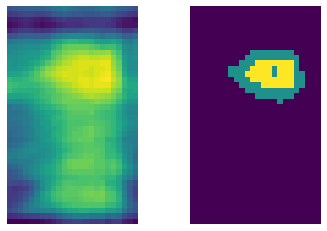

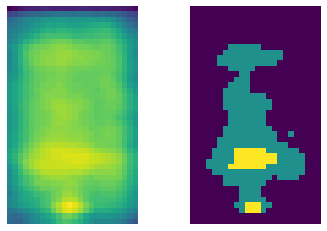

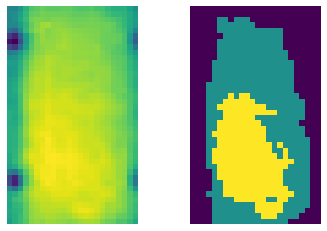

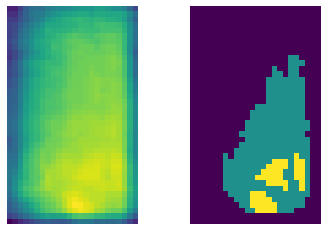

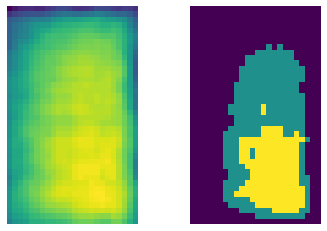

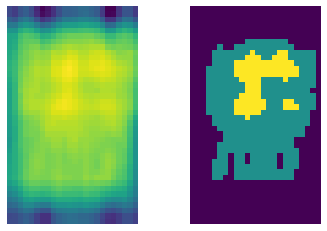

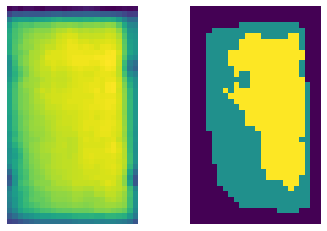

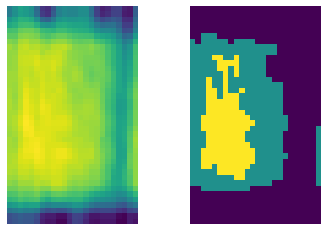

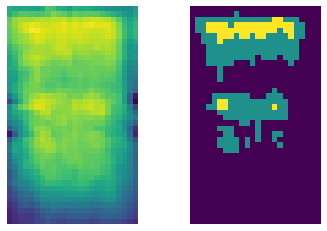

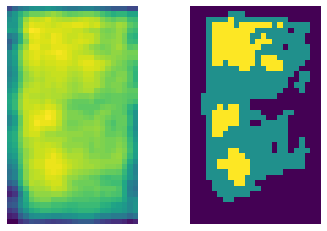

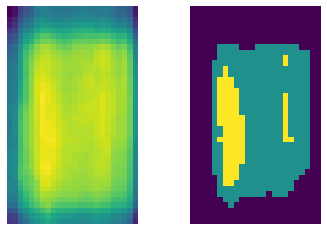

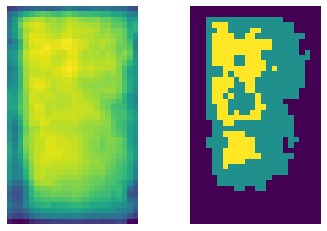

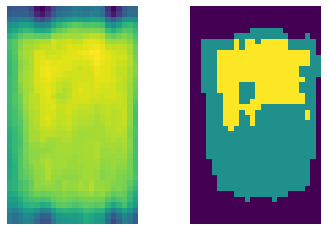

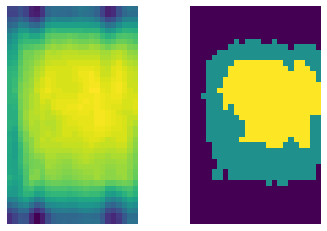

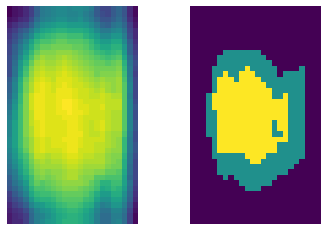

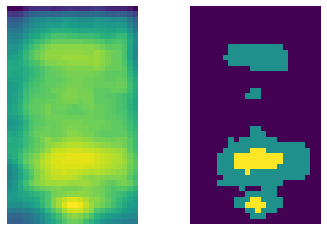

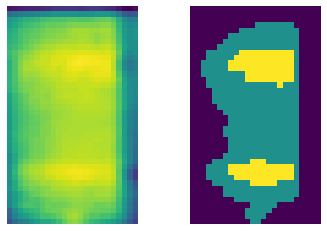

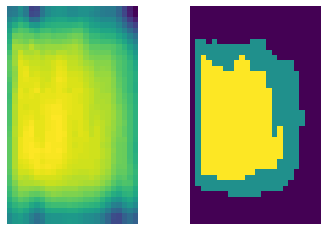

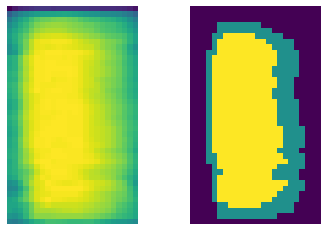

In [70]:
#for i in range(1, 20000):
#  image_binarizer(i, 0.8, 0.92, 0, 1)

for i in range(1, 20):
  image_binarizer(i, 0.8, 0.92, 1, 0)

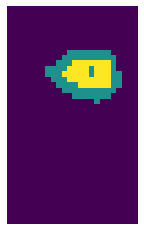

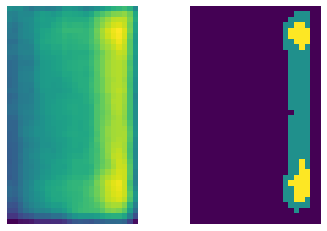

In [80]:
csv_im = pd.read_csv('/content/binary_images/1.csv', sep = ',', header=None)
plt.axis("off")
plt.imshow(csv_im)

image_binarizer(1323, 0.8, 0.92, 1, 0)

## Prepare Data Set

In [71]:
input_dir = "/content/InfraredSolarModules/images/"
target_dir = "/content/binary_images/"

input_img_paths = sorted([os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])
    
target_paths = sorted([os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".csv") and not fname.startswith(".")])

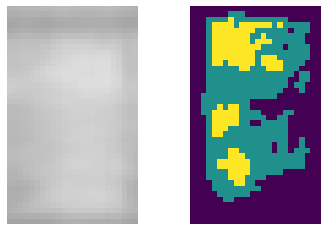

In [90]:
fig = plt.figure()
rows, columns = 1 , 2
fig.add_subplot(rows, columns, 1)
plt.axis("off")
plt.imshow(load_img(input_img_paths[1]))
fig.add_subplot(rows, columns, 2)
plt.axis("off")
plt.imshow(pd.read_csv((target_paths[1]), sep = ',', header=None))

### Load data into NumPy Array

In [37]:
img_size = (24, 40)
# Total number of samples in the data
num_imgs = len(input_img_paths)

# Shuffle the file paths (they were originally sorted by breed)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
    load_img(path, target_size=img_size, color_mode="grayscale"))
    # Subtract 1 so that our labels become 0, 1, and 2
    img = img.astype("uint8") - 1
    return img

# Load all images in the input_imgs float32 array and their masks in the
# targets uint8 array (same order). The inputs have three channels (RBG values)
# and the targets have a single channel (which contains integer labels)
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])
  
# Reserve 1000 samples for validation
num_val_samples = 1000
# Split the data into a training and a validation set
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

IndexError: ignored

## Build Model

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    # Don’t forget to rescale input images to the [0-1] range
    x = layers.Rescaling(1./255)(inputs)
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###
    for filters in [258, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # We end the model with a per-pixel three-way
    # softmax to classify each output pixel into one of our three categories
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes=3)
model.summary()

## Train Model

In [ ]:
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="unet_segmentation.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
] 

history = model.fit(train_input_imgs, train_targets,
    epochs=50,
    callbacks=callbacks,
    batch_size=64,
    validation_data=(val_input_imgs, val_targets))

## Model Evaluation

### Training and Validation Loss

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Compute Prediction

In [ ]:

model = keras.models.load_model("unet_segmentation.keras")
i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]

# Utility to display a model’s prediction
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)
    
display_mask(mask)